Here , we have implemented a knowledge graph from a WikiPedia actors dataset.
The article [1] by analyticsvidya has been heavily referred for this. But we have made improvements in the form of :
1. Data Preprocessing - Removed punctuations , stop words
2. Named Entity Recognition - This has helped in constructing a more meaningful graph with less noise.

Using Named Entity Recognition has helped us obtain top occuring Actors, writers,stuidio names etc 

In [1]:
import re
import pandas as pd
import spacy
from tqdm import tqdm
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load("en_core_web_sm")
from spacy.matcher import Matcher
import networkx as nx
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import string 
tqdm._instances.clear()

In [106]:
from google.colab import files
uploaded = files.upload()

Saving brusselsdata.csv to brusselsdata.csv


In [108]:
import io
sentences = pd.read_csv(io.BytesIO(uploaded['brusselsdata.csv']))

In [109]:
sentences.head()

,Unnamed: 0,sentence
0,0,"From the end of February, Belgium will start o..."
1,1,"On Wednesday, the Interministerial Conference ..."
2,2,"As for Moderna and Pfizer, the Novavax vaccine..."
3,3,"That is not on the agenda for right now, but i..."


Here are some sample sentences containing the words "bollywood" and "contemporary" together

In [8]:
sentences[sentences['sentence'].str.contains('keating' and 'Australia')]

,Unnamed: 0,sentence
1,1,"Australia ' s terms of trade also fell,by 18 %..."
5,5,This government is dragging Australia through ...
6,6,we are not pushing this place into a recession...


**Entity Pairs Extraction Function**

In [110]:
def get_entity(sent):
  ent1 = "" #subject entity
  ent2 = "" #object entity

  prev_token_text = "" #text from previous token
  prev_token_dep = ""  #depedency from previous token

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    #Go in only if it is not a punctuation, else next word
    if tok.dep_ != "punct":
      #Check if token is a compund word
      if tok.dep_ == "compound":
        prefix = tok.text
        #Check if previous token is also a compound
        if prev_token_dep == "compound":
          prefix = prev_token_text + " "+ prefix
      #Check if token is a modifier or not
      if tok.dep_.endswith("mod")==True:
        modifier = tok.text 
        #Check if previous token is a compound
        if prev_token_dep == "compound":
          modifier = prev_token_text + " " + modifier

      #Checking if subject
      if tok.dep_.find("subj") == True:
        ent1 =modifier+ " " + prefix + " " + tok.text
        prefix = ""
        modifer = ""
        prev_token_dep = ""
        prev_token_text = ""
      #Checking if object
      if tok.dep_.find("obj") == True:
        ent2 =modifier+ " " + prefix + " " + tok.text
        prefix = ""
        modifer = ""

      #Update variables
      prev_token_text = tok.text
      prev_token_dep = tok.dep_

      ############################
  return [ent1.strip(), ent2.strip()]    

Now lets obtain entity pairs from a sentence

In [111]:
[ent1,ent2] = get_entity("Paul keating is from Australia")
print("Subj : {a}, obj : {b}".format(a = ent1, b = ent2))
get_entity("Paul keating is from Australia")

Subj : Paul keating, obj : Australia


['Paul keating', 'Australia']

In [112]:
entity_pairs = []
for i in tqdm(sentences['sentence']):
  entity_pairs.append(get_entity(i))
tqdm._instances.clear()

100%|██████████| 4/4 [00:00<00:00, 68.41it/s]


In [113]:
subjects = []
objects = []
subjects = [x[0] for x in entity_pairs]
objects = [x[1] for x in entity_pairs]
subjects
objects

['first  Pfizer',
 '510,000  March',
 'yet booster shot',
 'soon,\\ Brussels Times']

**Relation** **Extraction** 

The Relation between nodes has been extracted. The hypothesis is that the main verb or the Root word forms the relation between the subject and the object.

In [144]:
from spacy.tokens import Token
#from spacy import Language

Token.set_extension('ref_n', default='', force = True)
Token.set_extension('ref_t', default='', force = True)

def get_relation(sent):
  doc = nlp(sent)
  #We initialise matcher with the vocab
  matcher = Matcher(nlp.vocab)
  #Defining the pattern
  pattern = [{'DEP':'ROOT'},{'DEP':'prep','OP':'?'},{'DEP':'VB','OP':'?'},{'DEP':'ADJ','OP':'?'}]
  
  #Adding the pattern to the matcher
  matcher.add("matcher_1",None,pattern)
  #Applying the matcher to the doc
  matches = matcher(doc)

  #The matcher returns a list of (match_id, start, end). The start to end in our doc contains the relation. We capture that relation in a variable called span
  span = doc[matches[0][1]:matches[0][2]]
  return span.text


Below we observe a problem. The Relation for the second should be "couldn't complete", in order to correctly capture the semantics. But it fails to do so.

In [145]:
get_entity("John completed the task"), get_relation("John completed the task")

(['John', 'task'], 'completed')

In [116]:
get_entity("John couldn't complete the task"), get_relation("John couldn't complete the task")

(['John', 'task'], 'complete')

Anyway, we move on. Let's get the relations for the entire dataset

In [117]:
relations = [get_relation(i) for i in tqdm(sentences['sentence'])]
tqdm._instances.clear()
relations

100%|██████████| 4/4 [00:00<00:00, 74.37it/s]


['start', 'decided', 'approved', 'is']

Let's look at the topmost occuring subjects 

In [118]:
pd.Series(subjects).value_counts()

who               1
510,000  which    1
three  vaccine    1
now  it           1
dtype: int64

We observe that these words are mostly generic, hence of not much use to us.


In [71]:
pd.Series(relations).value_counts()[:10]

said       3
told       1
REVISES    1
are        1
is         1
dtype: int64

Not surprisingly, "is" and "was" forms the most common relations, simply because they are the most common words. We want more meaningful subjects to be more prominent.

**Data Pre - Processing**

Let's see what happens if we pre-process the data.
We remove stopwords and punctuation marks

In [119]:
def isNotStopWord(word):
    return word not in stopwords.words('english')

def preprocess(sent):
  sent = re.sub("[\(\[].*?[\)\]]", "", sent)
  tokens = []
  temp = ""
  words = word_tokenize(sent)
  # Removing punctuations except '<.>/<?>/<!>'
  punctuations = '"#$%&\'()*+,-/:;<=>@\\^_`{|}~'
  words = map(lambda x: x.translate(str.maketrans('','',punctuations)), words)
  
  #Now, we remove the stopwords
  #words = map(str.lower,words)
  words = filter(lambda x: isNotStopWord(x),words)
  tokens = tokens + list(words)
  temp = ' '.join(word for word in tokens)
  return temp

In [120]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [121]:
preprocessed_sentences = [preprocess(i) for i in tqdm(sentences['sentence'])]
tqdm._instances.clear()
preprocessed_sentences

100%|██████████| 4/4 [00:00<00:00, 162.34it/s]


['From end February  Belgium start offering Novavax coronavirus vaccine – called Nuvaxovid – people allergic available vaccines proven side effects first dose Pfizer Moderna .',
 'On Wednesday  Interministerial Conference Public Health decided purchase 510000 doses vaccine – approved European Medicines Agency December – delivered end February beginning March .',
 'As Moderna Pfizer  Novavax vaccine requires two doses administered interval least three weeks. “ Currently  vaccine yet approved EMA booster shot .',
 'That agenda right  happen soon   ” Gudrun Briat  spokesperson Vaccination Taskforce  told The Brussels Times .']

Getting entity pairs from preprocessed sentences

In [122]:
entity_pairs = []
for i in tqdm(preprocessed_sentences):
  entity_pairs.append(get_entity(i))
tqdm._instances.clear()

100%|██████████| 4/4 [00:00<00:00, 82.58it/s]


In [123]:
relations = [get_relation(i) for i in tqdm(preprocessed_sentences)]
tqdm._instances.clear()

100%|██████████| 4/4 [00:00<00:00, 93.17it/s]


In [124]:
pd.Series(relations).value_counts()[:10]

dose        1
requires    1
decided     1
happen      1
dtype: int64

We see above that only the important relations are present, "released" being the most common. There is no "is", "was" and trivial words as before.This fulfils our desire if eliminating noise.

What if we only want Named Entities to be present? Entities like Actors, Films,
Studios, Composers etc

In [125]:
entity_pairs2 = entity_pairs
relations2 = relations

In [126]:
#We keep relations only for those entities whose both source and target are present
entity_pairs3 = []
relations3 = []
for i in tqdm(range(len(entity_pairs2))):
  if entity_pairs2[i][0]!='' and entity_pairs2[i][1]!='':
    entity_pairs3.append(entity_pairs2[i])
    relations3.append(relations2[i])
tqdm._instances.clear()

100%|██████████| 4/4 [00:00<00:00, 6495.24it/s]


As we observe, the number of relations decrease to 2851 . Previously it was around 4k

**Named Entity Recognition Using Spacy**

In [127]:
source = []
target = []
edge = []
for i in (range(len(entity_pairs))):
  doc_source = nlp(entity_pairs[i][0]).ents #Getting the named entities for source
  #Converting the named entity tuple to String
  str_source = [str(word) for word in doc_source]
  doc_source = ' '.join(str_source)
  doc_target = nlp(entity_pairs[i][1]).ents #Getting the named entities for target
  #Converting the named entity tuple to String
  str_target = [str(word) for word in doc_target]
  doc_target = ' '.join(str_target)
  if doc_source != '' or doc_target != '':
    edge.append(relations[i])
    source.append(entity_pairs[i][0])
    target.append(entity_pairs[i][1])


We had obtained entity pairs before but they had many irrelevant words.
We narrowed them down quite a bit by preprocessing. Now, we obtain the named entity pairs which will form source and target respectively.
It looks like (source, target, edge). We prune this further by removing all the data which have neither source or target entity as a Named Entity.
We keep the rest. The Relations that were extracted before form the edge

**Now, we find the most popular Source , Target and Relations**

In [128]:
print("###################  Most popular source entites    ###################### \n",pd.Series(source).value_counts()[:10])
print("###################  Most popular target entites    ###################### \n",pd.Series(target).value_counts()[:10])
print("###################  Most popular relations         ###################### \n",pd.Series(relations).value_counts()[:20])

###################  Most popular source entites    ###################### 
 available side effects                1
Currently  vaccine                    1
approved Medicines Agency December    1
dtype: int64
###################  Most popular target entites    ###################### 
 end February end March    1
first Pfizer Moderna      1
two  interval             1
dtype: int64
###################  Most popular relations         ###################### 
 dose        1
requires    1
decided     1
happen      1
dtype: int64


**Constructing the Knowledge Graph**

We first take the knowledge graph in a pandas dataframe. It will be a directional graph.

In [129]:
knowledge_graph_df = pd.DataFrame({'source':source, 'target':target, 'edge':edge})
knowledge_graph_df
#MultiDIGRaph because its a directional graph

,source,target,edge
0,available side effects,first Pfizer Moderna,dose
1,approved Medicines Agency December,end February end March,decided
2,Currently vaccine,two interval,requires


In [86]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

Let's see what we get when the source enity is "khan"

In [33]:
knowledge_graph_df[knowledge_graph_df['source']=="keating"]

,source,target,edge


In [131]:
G = nx.from_pandas_edgelist(knowledge_graph_df, source = 'source', target = 'target', edge_attr = True, create_using= nx.MultiDiGraph())
#MultiDIGRaph because its a directional graph

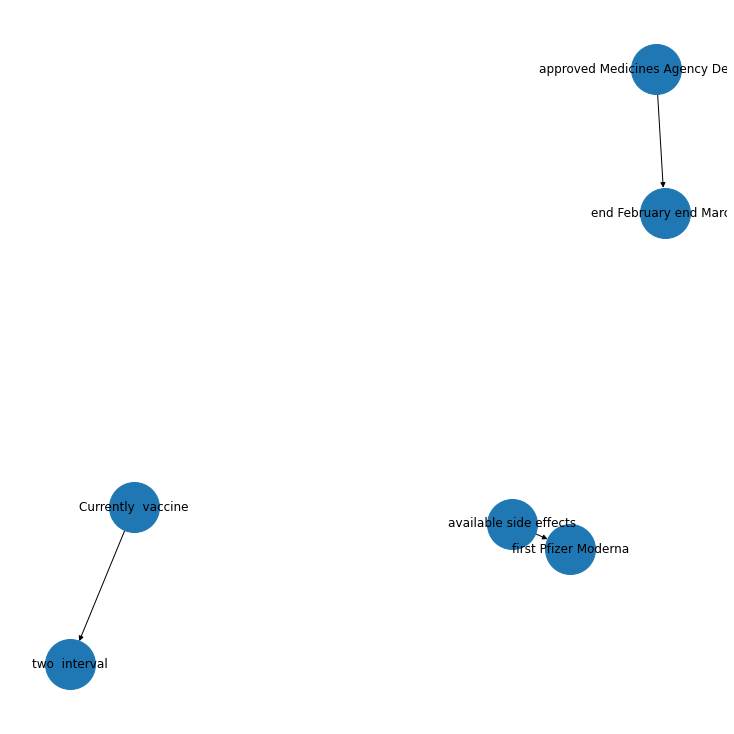

In [132]:
plt.figure(figsize = (10,10))
pox = nx.spring_layout(G,k = 1.0) #k defines the distnace between nodes
nx.draw(G, with_labels= True, node_size = 2500)
plt.show()

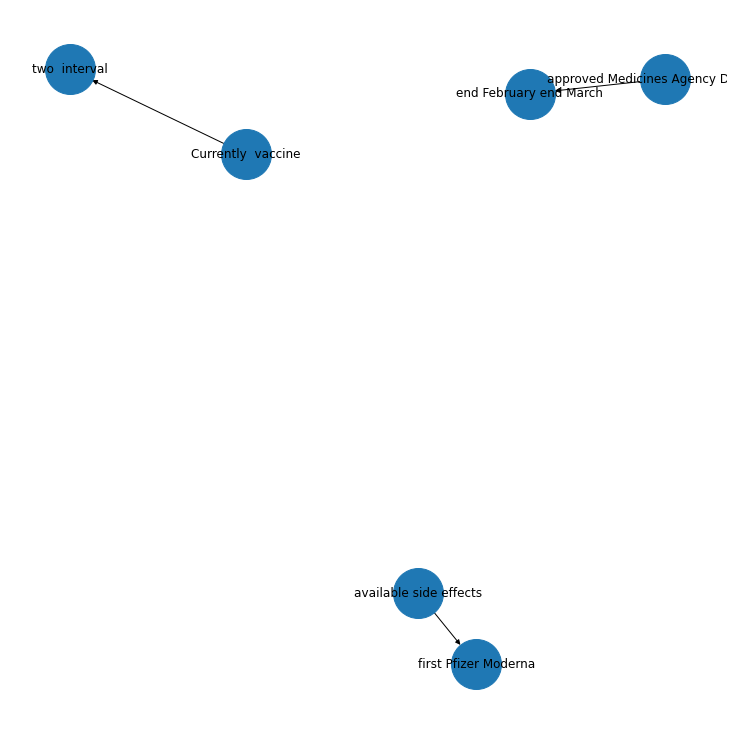

In [135]:
G = nx.from_pandas_edgelist(knowledge_graph_df,source = 'source', target = 'target', edge_attr = True, create_using= nx.MultiDiGraph())
plt.figure(figsize = (10,10))
pox = nx.spring_layout(G,k = 1.0) #k defines the distnace between nodes
nx.draw(G, with_labels= True, node_size = 2500)
plt.show()

So, for a very small dataset, we get some interesting graph structures which match with our intuition. We can further develop on this by taking a larger dataset and calculating some measures ,like degree centrality etc.

**References**
1. https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/